# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [3]:
from pprint import pformat as pf, pprint as pp
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://itermplot
0.10.1
1.17.2
0.25.1


# Fetch Data

In [4]:
url = 'http://192.168.0.156:8000/metrics?from=300'
response = requests.get(url)

In [5]:
#response.status_code = 404
if response.status_code == 200:
    print("web")
    data = json.loads(response.content.decode('utf-8'))
else:
    print("local")
    with open('sample.json', 'r') as f:
        data = json.load(f)


web


# Tidy Data

In [47]:
df = pd.DataFrame(data)
df

,metric,ts,value
0,humidity,1.574763e+09,55.155263
1,temperature,1.574763e+09,28.281578
2,humidity,1.574762e+09,55.061999
3,temperature,1.574762e+09,28.293999
4,humidity,1.574762e+09,54.840000
...,...,...,...
35677,temperature,1.569138e+09,24.498077
35678,humidity,1.569138e+09,78.126413
35679,temperature,1.569138e+09,24.500000
35680,humidity,1.569137e+09,78.282355


In [48]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df

,metric,ts,value
0,humidity,2019-11-26 10:04:23.728200674,55.155263
1,temperature,2019-11-26 10:04:23.728200674,28.281578
2,humidity,2019-11-26 10:00:00.954467535,55.061999
3,temperature,2019-11-26 10:00:00.954467535,28.293999
4,humidity,2019-11-26 09:55:01.115954399,54.840000
...,...,...,...
35677,temperature,2019-09-22 07:40:04.500892878,24.498077
35678,humidity,2019-09-22 07:35:00.818114996,78.126413
35679,temperature,2019-09-22 07:35:00.818114996,24.500000
35680,humidity,2019-09-22 07:30:08.879276752,78.282355


In [49]:
df = df.set_index('ts')
df

,metric,value
ts,,
2019-11-26 10:04:23.728200674,humidity,55.155263
2019-11-26 10:04:23.728200674,temperature,28.281578
2019-11-26 10:00:00.954467535,humidity,55.061999
2019-11-26 10:00:00.954467535,temperature,28.293999
2019-11-26 09:55:01.115954399,humidity,54.840000
...,...,...
2019-09-22 07:40:04.500892878,temperature,24.498077
2019-09-22 07:35:00.818114996,humidity,78.126413
2019-09-22 07:35:00.818114996,temperature,24.500000


In [50]:
df = df.dropna()
df_temp = df[df['metric'] == 'temperature'][['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00', '2019-09-22 08:00:00',
               '2019-09-22 09:00:00', '2019-09-22 10:00:00',
               '2019-09-22 11:00:00', '2019-09-22 12:00:00',
               '2019-09-22 13:00:00', '2019-09-22 14:00:00',
               '2019-09-22 15:00:00', '2019-09-22 16:00:00',
               ...
               '2019-11-26 01:00:00', '2019-11-26 02:00:00',
               '2019-11-26 03:00:00', '2019-11-26 04:00:00',
               '2019-11-26 05:00:00', '2019-11-26 06:00:00',
               '2019-11-26 07:00:00', '2019-11-26 08:00:00',
               '2019-11-26 09:00:00', '2019-11-26 10:00:00'],
              dtype='datetime64[ns]', name='ts', length=1564, freq='H')

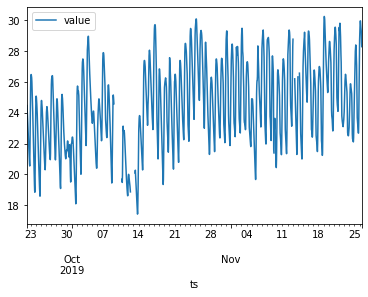

In [51]:
df_temp.plot()

# Differencing

In [52]:
df_lag = df_temp.shift()

In [53]:
df_diff = df_temp - df_lag

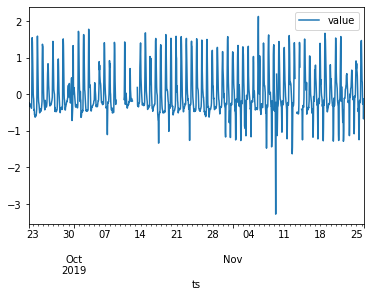

In [54]:
df_diff.plot()

In [55]:
df_acf = pd.DataFrame(stattools.acf(df_temp.dropna(), fft=True))

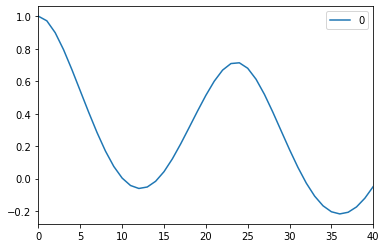

In [56]:
df_acf.plot()

In [57]:
df_pacf = pd.DataFrame(stattools.pacf(df_temp.dropna(), method='ols-inefficient'))

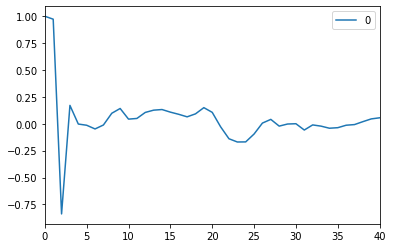

In [58]:
df_pacf.plot()

In [59]:
df_pacf[:6]

,0
0,1.000000
1,0.972626
2,-0.838324
3,0.170943
4,-0.002516
5,-0.013720


## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# ARIMA

In [60]:
df_temp.to_csv("data.csv")

In [61]:
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00', '2019-09-22 08:00:00',
               '2019-09-22 09:00:00', '2019-09-22 10:00:00',
               '2019-09-22 11:00:00', '2019-09-22 12:00:00',
               '2019-09-22 13:00:00', '2019-09-22 14:00:00',
               '2019-09-22 15:00:00', '2019-09-22 16:00:00',
               ...
               '2019-11-26 01:00:00', '2019-11-26 02:00:00',
               '2019-11-26 03:00:00', '2019-11-26 04:00:00',
               '2019-11-26 05:00:00', '2019-11-26 06:00:00',
               '2019-11-26 07:00:00', '2019-11-26 08:00:00',
               '2019-11-26 09:00:00', '2019-11-26 10:00:00'],
              dtype='datetime64[ns]', name='ts', length=1564, freq='H')

In [98]:
model = ARIMA(df_temp.dropna(), (2,1,2)).fit(disp=False)

/Users/jpeak/projects/temperature-timeseries/v/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jpeak/projects/temperature-timeseries/v/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [99]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                 1492
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -472.515
Method:                       css-mle   S.D. of innovations              0.332
Date:                Tue, 26 Nov 2019   AIC                            957.031
Time:                        21:40:10   BIC                            988.878
Sample:                             1   HQIC                           968.898
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0022      0.005      0.466      0.641      -0.007       0.011
ar.L1.D.value     1.7360      0.018     97.392      0.000       1.701       1.771
ar.L2.D.value    -0.8092      0.018    -44.887      0.000      -0.844      -0.774
ma.L1.D.value    -0.8143      0.031    -26.679      0.000      -0.874      -0.754
ma.L2.D.value    -0.1467      0.032     -4.581      0.000      -0.209      -0.084
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0727           -0.2918j            1.1117           -0.0423
AR.2            1.0727           +0.2918j            1.1117            0.0423
MA.1            1.0351           +0.0000j            1.0351            0.0000
MA.2           -6.5853           +0.0000j            6.5853            0.5000
-----------------------------------------------------------------------------
"""